**Exercise 6.4**

MNIST with fully connected networks and grid/random search

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import layers

plt.style.use("seaborn-v0_8")

The MNIST data base of handwritten numbers is directly available through KERAS. The following codeblocks download and preprocess the data.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_valid = x_test[8000:]
y_valid = y_test[8000:]
x_test = x_test[:8000]
y_test = y_test[:8000]

# Hint: convert integer RGB values (0-255) to float values (0-1)


In [3]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_valid.shape[0], "validation samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28)
60000 train samples
2000 validation samples
8000 test samples


In this exercise, a fully connected neural network is used to predict the handwritten numbers. To do this, we reformat the pictures with 28x28 pixels into a vector with a length of 28x28=784.

In [4]:
# reshape the image matrices to vectors
x_train = x_train.reshape(-1, 28**2)
x_valid = x_valid.reshape(-1, 28**2)
x_test = x_test.reshape(-1, 28**2)
print("x_train shape:", x_train.shape)

x_train shape: (60000, 784)


We use "onehot" encoding of the classes. This means a "zero" is encoded as `[1,0,0,0,0,0,0,0,0,0]` and a "one" as `[0,1,0,0,0,0,0,0,0,0]` etc.
This is done because our network will have ten output nodes with the output node with the largest value being the predicted number.

In [5]:
# convert class vectors to binary class matrices (10 numbers/classes)
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

In [6]:
# define model here
nb_nodes = 128
activation = "relu"
output = 10
drop_rate = 0.5 # Between 0.2 and 0.5

model = tf.keras.models.Sequential([
    layers.Dense(nb_nodes, activation=activation, input_shape=(784,)),
    layers.Dropout(drop_rate), 
    layers.Dense(output), # output
    # softmax activation to transform output into probabilities
    layers.Activation('softmax')])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
model.compile(
    # the recommended loss for a classification task is 'categorical_crossentropy'
    # (see lecture for details)
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

# define callbacks for training
save_best = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{}.weights.h5".format(model.name),
    save_best_only=True,
    monitor="val_accuracy",
    save_weights_only=True,
)

# Keras calculates training accuracy and loss during the training and
# with regularization applied, while the validation metrics are calculated
# at the end of each epoch. This callback calculates the training metrics
# the same way as for the validation
class CalculateMetrics(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        train_loss, train_acc = model.evaluate(x_train, y_train_onehot, verbose=0)
        logs["train_loss"] = train_loss
        logs["train_acc"] = train_acc

results = model.fit(
    x_train, y_train_onehot,
    validation_data=(x_valid, y_valid_onehot),

    batch_size=784,
    epochs=10,
    callbacks=[
        save_best,
        CalculateMetrics(),
        tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))
    ]
)

Epoch 1/10
 1/77 [..............................] - ETA: 14s - loss: 222.8979 - accuracy: 0.1173

2025-11-14 15:15:28.176149: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


77/77 [==============================] - 1s 11ms/step - loss: 18.5861 - accuracy: 0.4662 - val_loss: 1.3134 - val_accuracy: 0.5660 - train_loss: 1.4130 - train_acc: 0.5611
Epoch 2/10
77/77 [==============================] - 1s 10ms/step - loss: 1.7140 - accuracy: 0.5030 - val_loss: 0.9633 - val_accuracy: 0.7470 - train_loss: 1.0885 - train_acc: 0.7222
Epoch 3/10
77/77 [==============================] - 1s 10ms/step - loss: 1.4642 - accuracy: 0.5966 - val_loss: 0.8049 - val_accuracy: 0.8050 - train_loss: 0.9060 - train_acc: 0.7717
Epoch 4/10
77/77 [==============================] - 1s 10ms/step - loss: 1.2637 - accuracy: 0.6505 - val_loss: 0.6972 - val_accuracy: 0.8385 - train_loss: 0.7695 - train_acc: 0.8106
Epoch 5/10
77/77 [==============================] - 1s 10ms/step - loss: 1.1189 - accuracy: 0.6866 - val_loss: 0.6332 - val_accuracy: 0.8755 - train_loss: 0.6760 - train_acc: 0.8451
Epoch 6/10
77/77 [==============================] - 1s 10ms/step - loss: 1.0352 - accuracy: 0.7138 -

In [8]:
# load best model
model.load_weights(f"best_model_{model.name}.weights.h5")

# ------------------------
# ---     Plotting     ---
# ------------------------

# plot training history
history = np.genfromtxt(f"history_{model.name}.csv", delimiter=",", names=True)
# add plots below


In [9]:
# evaluate performance

print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    [
        "Train",
        *model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128),
        (1 - model.evaluate(x_train, y_train_onehot, verbose=0, batch_size=128)[1])
        * 100,
    ],
    [
        "Validation",
        *model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128),
        (1 - model.evaluate(x_valid, y_valid_onehot, verbose=0, batch_size=128)[1])
        * 100,
    ],
    [
        "Test",
        *model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128),
        (1 - model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1]) * 100,
    ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |     Loss |   Accuracy |   Test error rate [%] |
|------------+----------+------------+-----------------------|
| Train      | 0.405699 |   0.897583 |               10.2417 |
| Validation | 0.419212 |   0.918    |                8.2    |
| Test       | 0.622597 |   0.877875 |               12.2125 |


You can compare your own results with a variety of different models: http://yann.lecun.com/exdb/mnist/ and https://en.wikipedia.org/wiki/MNIST_database

The following codeblocks define some helper functions for plotting. You don't need to touch them

In [10]:
# @title
def plot_image(X, ax=None):
    """Plot an image X.

    Args:
        X (2D array): image, grayscale or RGB
        ax (None, optional): Description
    """
    if ax is None:
        ax = plt.gca()

    if (X.ndim == 2) or (X.shape[-1] == 1):
        ax.imshow(X.astype("uint8"), origin="upper", cmap=plt.cm.Greys)
    else:
        ax.imshow(X.astype("uint8"), origin="upper")

    ax.set(xticks=[], yticks=[])


def plot_prediction(Yp, X, y, classes=None, top_n=False):
    """Plot an image along with all or the top_n predictions.

    Args:
        Yp (1D array): predicted probabilities for each class
        X (2D array): image
        y (integer): true class label
        classes (1D array, optional): class names
        top_n (int, optional): number of top predictions to show
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3.2))
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.98, wspace=0.02)
    plot_image(X, ax1)

    if top_n:
        n = top_n
        s = np.argsort(Yp)[-top_n:]
    else:
        n = len(Yp)
        s = np.arange(n)[::-1]

    patches = ax2.barh(np.arange(n), Yp[s], align="center")
    ax2.set(xlim=(0, 1), xlabel="Probability", yticks=[])

    for iy, patch in zip(s, patches):
        if iy == y:
            patch.set_facecolor("C1")  # color correct patch

    if classes is None:
        classes = np.arange(0, np.size(Yp))

    for i in range(n):
        ax2.text(0.05, i, classes[s][i], ha="left", va="center")

    plt.show()


def plot_confusion(yp, y, classes=None, fname=None):
    """Plot confusion matrix for given true and predicted class labels

    Args:
        yp (1D array): predicted class labels
        y (1D array): true class labels
        classes (1D array): class names
        fname (str, optional): filename for saving the plot
    """
    if classes is None:
        n = max(max(yp), max(y)) + 1
        classes = np.arange(n)
    else:
        n = len(classes)

    bins = np.linspace(-0.5, n - 0.5, n + 1)
    C = np.histogram2d(y, yp, bins=bins)[0]
    C = C / np.sum(C, axis=0) * 100

    _ = plt.figure(figsize=(8, 8))
    plt.imshow(C, interpolation="nearest", vmin=0, vmax=100, cmap=plt.cm.YlGnBu)
    plt.gca().set_aspect("equal")
    cbar = plt.colorbar(shrink=0.8)
    cbar.set_label("Frequency %")
    plt.xlabel("Prediction")
    plt.ylabel("Truth")
    plt.xticks(range(n), classes, rotation="vertical")
    plt.yticks(range(n), classes)
    for x in range(n):
        for y in range(n):
            if np.isnan(C[x, y]):
                continue
            color = "white" if x == y else "black"
            plt.annotate(
                "%.1f" % (C[x, y]), xy=(y, x), color=color, ha="center", va="center"
            )

    plt.show()

63/63 [==============================] - 0s 445us/step


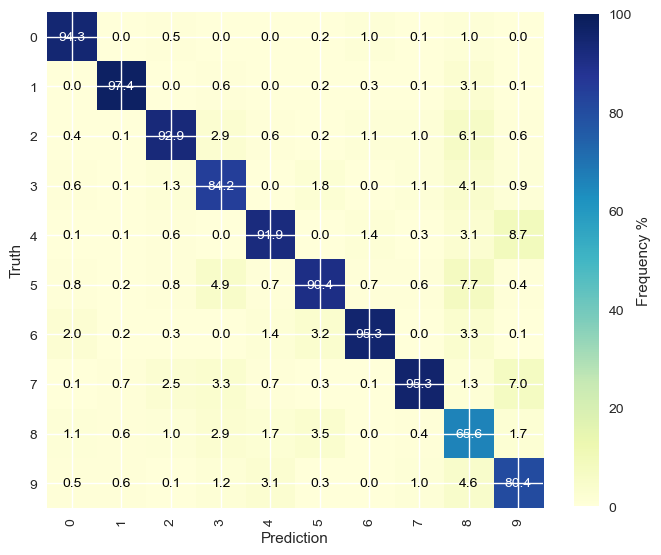

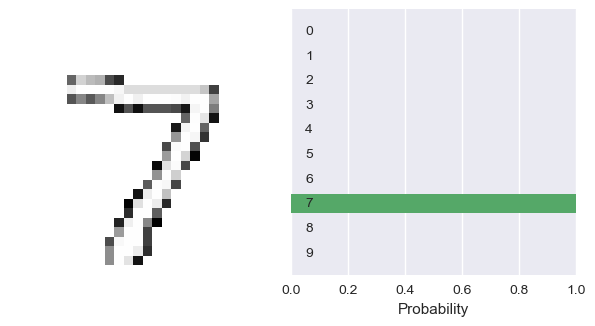

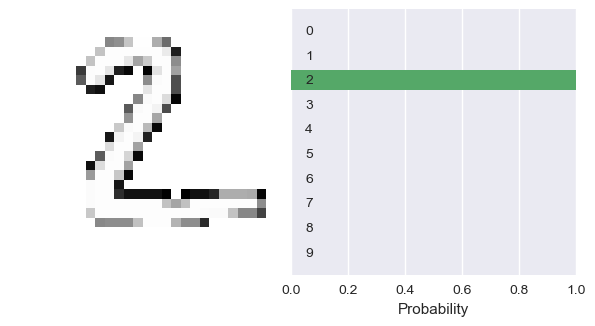

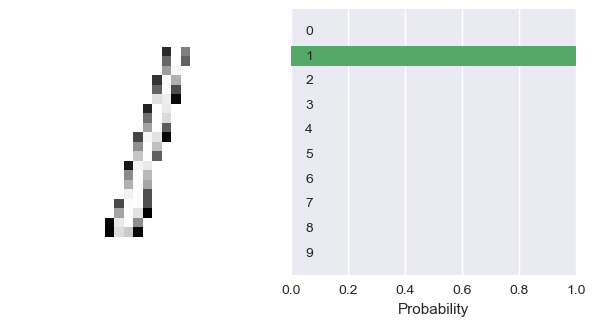

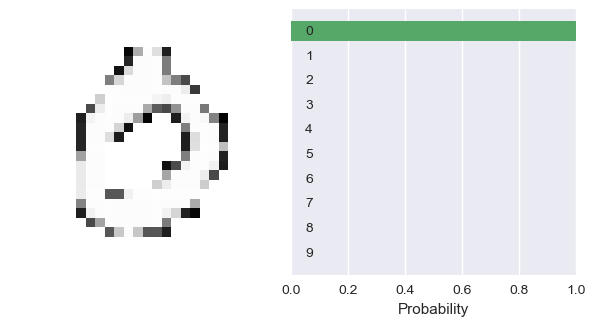

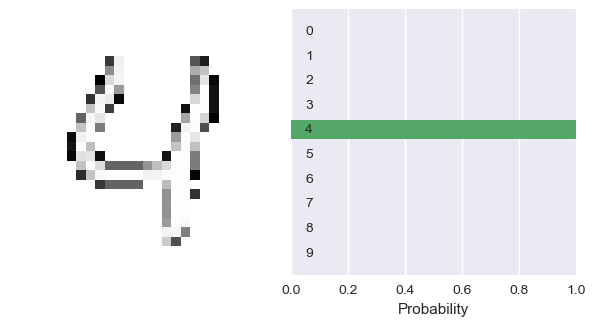

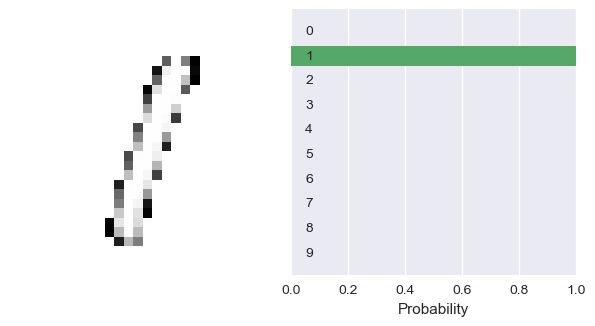

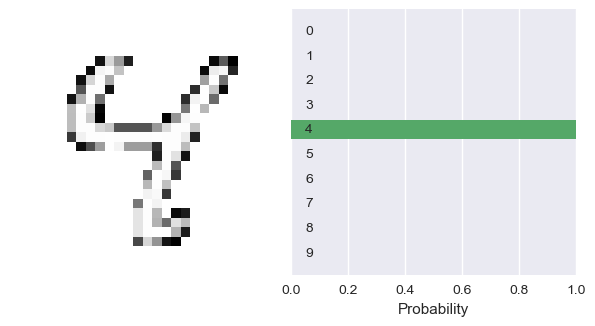

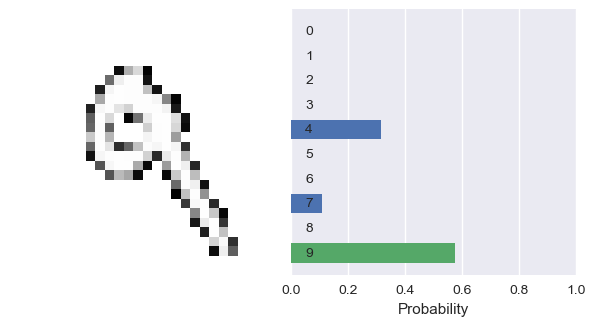

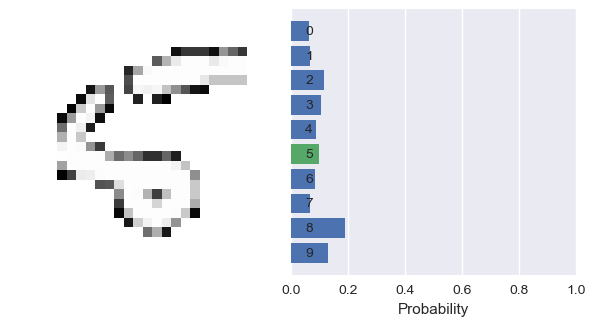

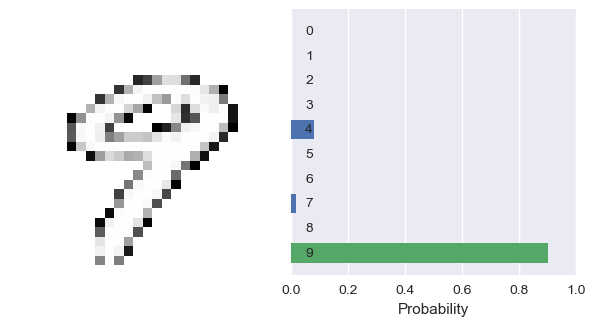

In [11]:
# plot a few examples, loop over test dataset:
# get missidentified samples
output = model.predict(x_test, batch_size=128)
labels = np.argmax(y_test_onehot, axis=1)
predictions = np.argmax(output, axis=1)
plot_confusion(predictions, labels)

for i in range(10): # loop over first 10 test samples
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])


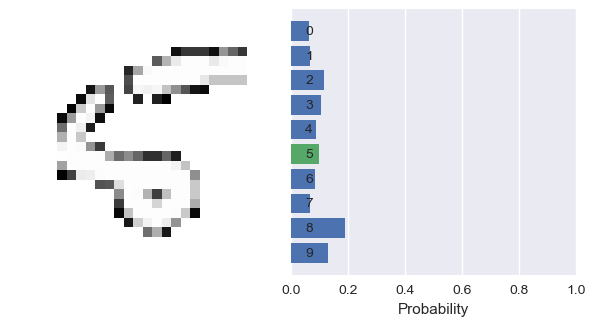

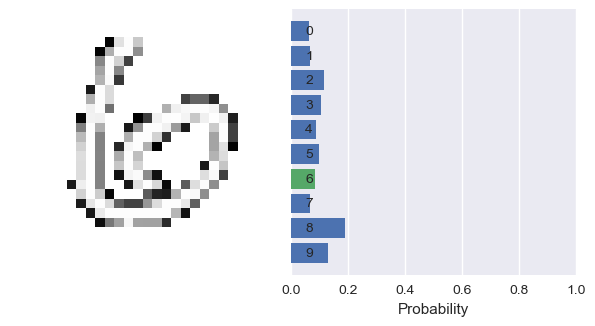

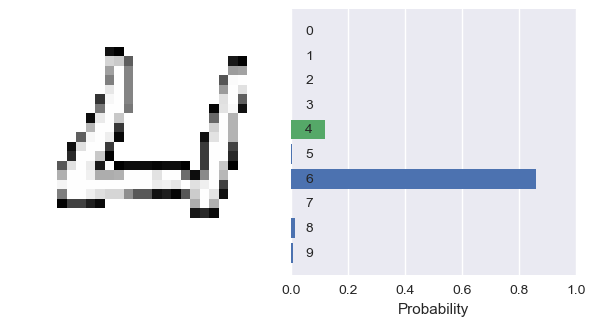

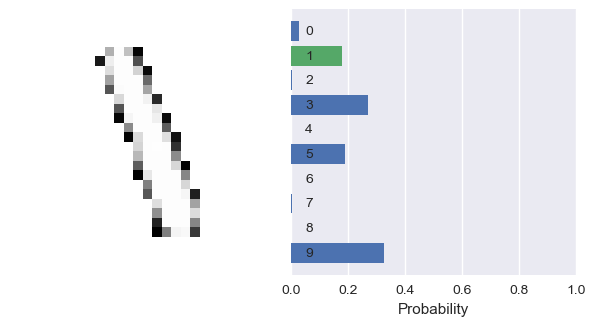

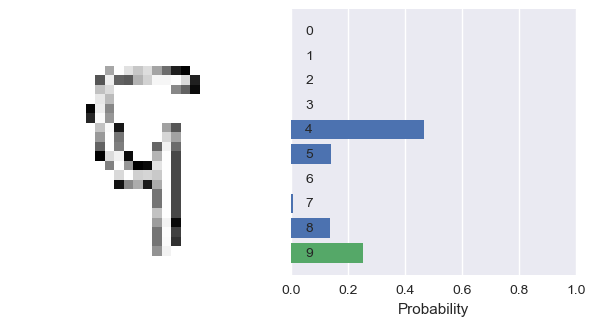

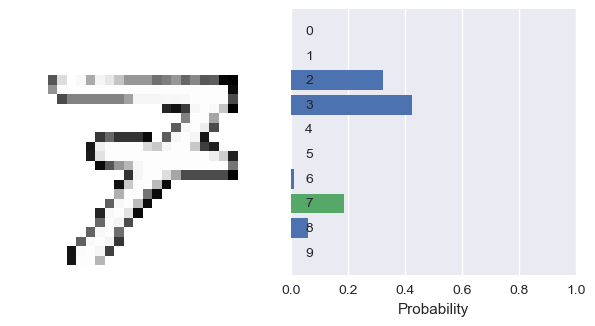

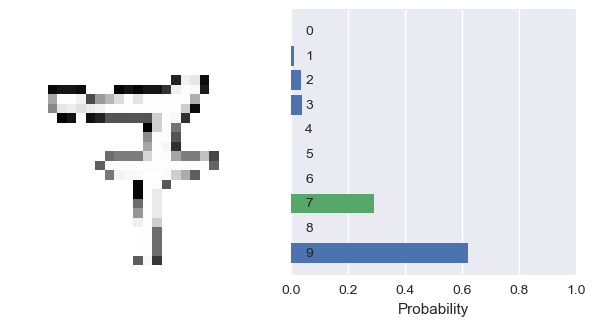

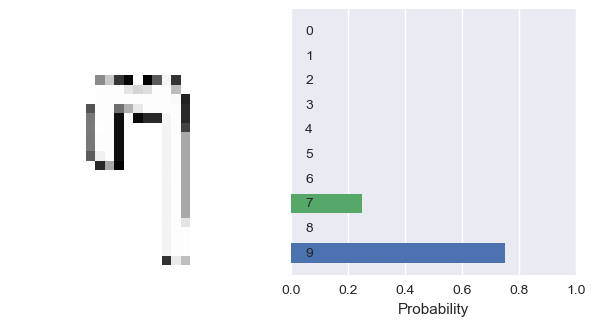

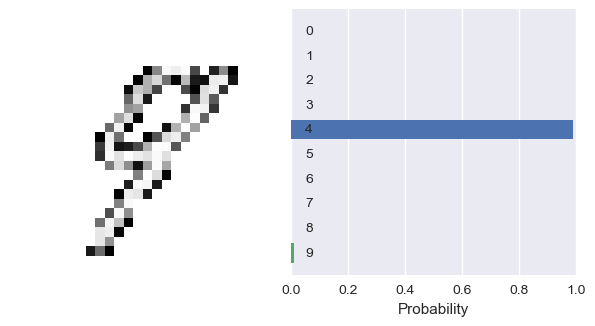

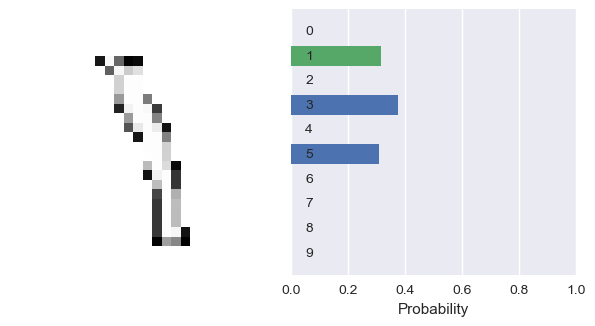

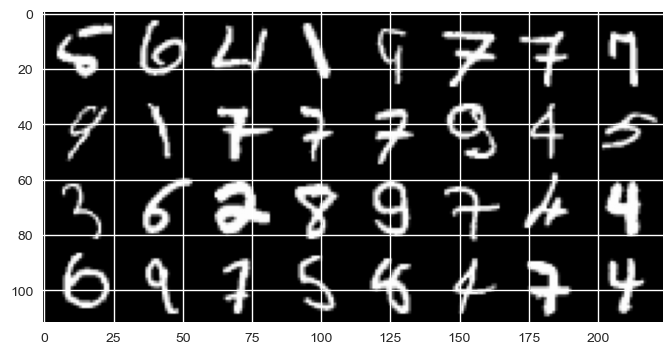

In [12]:
# now plot a few examples that were misclassified

indices_miss = np.nonzero(predictions != labels)[0]
x_missid = x_test[indices_miss]

for i in indices_miss[:10]:
    plot_prediction(output[i],
                    255 * np.reshape(x_test[i], (28, 28)), # we need to reshape the data into an image and convert back to RGB color scale by multiplying with 255
                    labels[i])

# or plot 32 of them in a joint plot
fig = plt.figure()
ax = fig.add_subplot(111)
plotdata = x_missid[:32]
plotdata = np.hstack(np.concatenate(np.reshape(plotdata, (4, 8, 28, 28)), axis=1))
ax.imshow(plotdata, cmap="gray")


**Grid search**

Let's search the two hyperparameters dropout and number of nodes. You can start from the template below.



In [13]:
# Experiment with diﬀerent network structures (diﬀerent number of neurons and hidden layers)
# to see how the performance increases. Report your results.
dropout_values = [0.2, 0.22, 0.24, 0.26, 0.28, 0.3]
n_neurons_values = [10, 20, 50, 100, 200, 500]
results_gridsearch = np.zeros((len(dropout_values), len(n_neurons_values), 2))
for iDrop, drop in enumerate(dropout_values):
  for iN, n_neurons in enumerate(n_neurons_values):
    model = tf.keras.models.Sequential([
        layers.Dense(n_neurons, activation="relu", input_shape=(784,)),
        layers.Dropout(drop),
        layers.Dense(10),
        # softmax actication to transform output into probabilities
        layers.Activation('softmax')])

    model.compile(
        # the recommended loss for a classification task is 'categorical_crossentropy'
        # (see lecture for details)
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
        metrics=['accuracy']) # we use accuracy to quanitfy to network performance.

    results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=784,
        epochs=10,
        verbose=0
        )
    t = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)
    results_gridsearch[iDrop, iN] = t
    print(f"dropout = {drop:.2f}, {n_neurons} neurons -> accuracy {results_gridsearch[iDrop, iN][1]:.3f}, error rate = {100*(1-results_gridsearch[iDrop, iN][1]):.1f}%")


dropout = 0.20, 10 neurons -> accuracy 0.307, error rate = 69.3%
dropout = 0.20, 20 neurons -> accuracy 0.410, error rate = 59.0%
dropout = 0.20, 50 neurons -> accuracy 0.853, error rate = 14.7%
dropout = 0.20, 100 neurons -> accuracy 0.910, error rate = 9.0%
dropout = 0.20, 200 neurons -> accuracy 0.930, error rate = 7.0%
dropout = 0.20, 500 neurons -> accuracy 0.959, error rate = 4.1%
dropout = 0.22, 10 neurons -> accuracy 0.290, error rate = 71.0%
dropout = 0.22, 20 neurons -> accuracy 0.649, error rate = 35.1%
dropout = 0.22, 50 neurons -> accuracy 0.848, error rate = 15.2%
dropout = 0.22, 100 neurons -> accuracy 0.903, error rate = 9.7%
dropout = 0.22, 200 neurons -> accuracy 0.929, error rate = 7.1%
dropout = 0.22, 500 neurons -> accuracy 0.961, error rate = 3.9%
dropout = 0.24, 10 neurons -> accuracy 0.203, error rate = 79.7%
dropout = 0.24, 20 neurons -> accuracy 0.601, error rate = 39.9%
dropout = 0.24, 50 neurons -> accuracy 0.851, error rate = 14.9%
dropout = 0.24, 100 neuro

It was seen that a NN with more neurons increases it's accuracy and with lower percentage of dropout values increased as well.
Dropouts between 0.2 to 0.5 in increments of 0.1 where studied and values n_neurons between 10 to 50 intervals where studied.
After several tunning it was found that the best confguration is a dropout of 0.22 and 500 neurons

**Random seach**

Now lets implement a random search. A random search allows us to scan more hyperparameters at once without more computing time. You can start from the template below.




In [14]:
N = 20 # number of trials
search = {
    'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
    'num_neurons': np.random.choice([8, 32, 128, 256, 512], N),
    'learn_rate': np.random.choice([-5,-4, -3, -2, -1],N),
    'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
    'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
    'val_acc': np.zeros(N)
}

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(search['batch_size'][i], activation = search['activation'][i], input_shape=(784,)),
                      tf.keras.layers.Dropout(search['dropout'][i]),
                      tf.keras.layers.Dense(10, activation='softmax')])
  model.compile(loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['accuracy'])
  results = model.fit(
        x_train, y_train_onehot,
        validation_data=(x_valid, y_valid_onehot),
        batch_size=784,
        epochs=10,
        verbose=0
      )
  search['val_acc'][i] = model.evaluate(x_test, y_test_onehot, verbose=0, batch_size=128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")


iteration 0:
	batch_size: 64
	num_neurons: 8
	learn_rate: -3
	activation: relu
	dropout: 0.1
	val_acc: 0.8828750252723694
	-> accuracy 0.883, error rate = 11.7%
iteration 1:
	batch_size: 64
	num_neurons: 128
	learn_rate: -3
	activation: relu
	dropout: 0.3
	val_acc: 0.8616250157356262
	-> accuracy 0.862, error rate = 13.8%
iteration 2:
	batch_size: 128
	num_neurons: 8
	learn_rate: -3
	activation: tanh
	dropout: 0.3
	val_acc: 0.925000011920929
	-> accuracy 0.925, error rate = 7.5%
iteration 3:
	batch_size: 256
	num_neurons: 512
	learn_rate: -1
	activation: elu
	dropout: 0.3
	val_acc: 0.9394999742507935
	-> accuracy 0.939, error rate = 6.1%
iteration 4:
	batch_size: 64
	num_neurons: 512
	learn_rate: -5
	activation: elu
	dropout: 0.2
	val_acc: 0.8758749961853027
	-> accuracy 0.876, error rate = 12.4%
iteration 5:
	batch_size: 256
	num_neurons: 512
	learn_rate: -4
	activation: elu
	dropout: 0.2
	val_acc: 0.9461249709129333
	-> accuracy 0.946, error rate = 5.4%
iteration 6:
	batch_size: 256
